# Step 2: Data Wrangling
In this notebook, the data from all 3 tables are read in and an initial cleaning process is done to fill empty values, discard of unnecessary features and choosing relevant identifiers and features. Ultimately, only the material flow and error message tables are used and merged to a new table.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import math
%matplotlib inline

## Load data from SQL file

### Inspect database

In [1]:
con = sqlite3.connect('../data/data2.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

NameError: name 'sqlite3' is not defined

### Function(s) needed for analysis

In [3]:
def empty_features(df,threshold=0.9):
    # defines string containing feature names for features that are 90% or more empty (or zero) 
    # or contain only one value (without being empty)
    # df: data frame that is searched for empty features
    # threshold: defines the threshold for the 'almost empty' classification, e.g. 0.8 means 80% or more of the data
    #      is empty. Note that the threshold for 'zero-empty' is always 90% to avoid misinterpretation with other data
    # returns an array containing all feature/column names that are classified as empty
    str_empty = []
    for var in df.columns:
        if (sum(df[var].isna()) >=  (threshold*df.shape[0])) | (sum(df[var]==0) >=  (0.9*df.shape[0])) | (df[var].nunique(dropna=False)==1):
            str_empty.append(var)  
        elif '999' in df[var]:
            if (sum(df[var].isna())+sum(df[var]== '999') >=  (threshold*df.shape[0])):
                str_empty.append(var)  
        #elif ('id' in var) & (sum(df[var].isna())+sum(df[var]== 0) >=  (threshold*df.shape[0])):
         #       str_empty.append(var)  
    return str_empty;

## Load MF (material flow) data

In [3]:
df_mf = pd.read_sql('SELECT * FROM data','sqlite:///../data/data2.db',index_col='index')
df_mf.head()

,id_000,ty_000,cl_000,xx_000,id_001,xx_001,cl_001,id_002,id_003,id_004,...,xx_024,xx_025,xx_026,flg_004,dt_001,xx_027,xx_028,xx_029,ty_006,id_033
index,,,,,,,,,,,,,,,,,,,,,
0,372892,ty_000_007,cl_000_001,5,None,xx_001_000,cl_001_001,1.0,None,None,...,0,0,64,0,2020-04-09 06:01:09,xx_027_002,0,xx_029_000,ty_006_000,1041973
1,372893,ty_000_010,cl_000_000,5,None,xx_001_000,cl_001_000,1.0,None,None,...,0,0,41,0,2020-04-09 06:01:39,xx_027_001,0,xx_029_000,ty_006_000,1041974
2,372894,ty_000_010,cl_000_000,5,None,xx_001_000,cl_001_000,2.0,None,None,...,0,0,44,0,2020-04-09 06:01:39,xx_027_001,0,xx_029_000,ty_006_000,1041975
3,372893,ty_000_010,cl_000_000,20,None,xx_001_000,cl_001_000,1.0,None,None,...,0,0,50,0,2020-04-09 06:01:39,xx_027_001,2,xx_029_001,ty_006_001,1041976
4,372894,ty_000_010,cl_000_000,20,None,xx_001_000,cl_001_000,2.0,None,None,...,0,0,53,0,2020-04-09 06:01:39,xx_027_001,2,xx_029_001,ty_006_001,1041977


In [4]:
df_mf.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 38431
Data columns (total 87 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_000   38432 non-null  int64  
 1   ty_000   38432 non-null  object 
 2   cl_000   38432 non-null  object 
 3   xx_000   38432 non-null  int64  
 4   id_001   36728 non-null  object 
 5   xx_001   27443 non-null  object 
 6   cl_001   26249 non-null  object 
 7   id_002   26210 non-null  float64
 8   id_003   34015 non-null  object 
 9   id_004   34015 non-null  object 
 10  id_005   22620 non-null  object 
 11  id_006   22620 non-null  object 
 12  id_007   20080 non-null  object 
 13  id_008   13437 non-null  object 
 14  id_009   132 non-null    object 
 15  id_010   132 non-null    object 
 16  id_011   2389 non-null   object 
 17  id_012   2389 non-null   object 
 18  xx_002   38432 non-null  int64  
 19  xx_003   38432 non-null  int64  
 20  ty_001   38432 non-null  int64  
 21  xx_004   261

Identify the distribution of filled and not filled features

In [5]:
thres = [0.9, 0.75, 0.5, 0.25,0.01]
num_feat = np.zeros(6)
k = 0
for t in thres:
    num_feat[k] = len(empty_features(df_mf,threshold=t))
    k += 1

num_feat[1:-1] = num_feat[1:-1]-num_feat[0:-2]
num_feat[-1] = df_mf.shape[1]-sum(num_feat)

In [6]:
print('Distribution of filled data:')
ranges = ['>90% empty','75-90% empty','50-75% empty','25-50% empty','0.1-25% empty','full']
num_feat_per = num_feat/df_mf.shape[1]*100
for i in range(len(num_feat)):
    print(' {} :: {} ({}%)'.format(ranges[i],num_feat[i],np.round(num_feat_per[i],1)))



Distribution of filled data:
 >90% empty :: 51.0 (58.6%)
 75-90% empty :: 7.0 (8.0%)
 50-75% empty :: 6.0 (6.9%)
 25-50% empty :: 6.0 (6.9%)
 0.1-25% empty :: 3.0 (3.4%)
 full :: 14.0 (16.1%)


In [7]:
print('Date range:')
print(df_mf.dt_001[0],df_mf.dt_001.iloc[-1])

Date range:
2020-04-09 06:01:09 2020-04-27 14:55:09


### Perform some basic data cleaning

In [8]:
for var in df_mf.columns:
    if '999' in df_mf[var].unique():
        df_mf.loc[df_mf[var]=='999',var] = np.NaN
        print(var,'999')
    elif ('id' in var) & (0 in df_mf[var].unique()):
        df_mf.loc[df_mf[var]==0,var] = np.NaN
        print(var)

/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


cl_005 999
id_021
id_022
id_023
id_025
id_031


In [9]:
str_empty = empty_features(df_mf)
print(np.sort(str_empty))
print(len(str_empty))

['cl_002' 'cl_004' 'cl_005' 'dt_000' 'flg_000' 'flg_002' 'flg_003'
 'flg_004' 'id_009' 'id_010' 'id_011' 'id_012' 'id_013' 'id_014' 'id_015'
 'id_016' 'id_017' 'id_020' 'id_021' 'id_022' 'id_023' 'id_025' 'id_027'
 'id_028' 'id_029' 'id_030' 'id_031' 'id_032' 'ty_001' 'ty_003' 'ty_005'
 'xx_002' 'xx_003' 'xx_004' 'xx_006' 'xx_007' 'xx_008' 'xx_009' 'xx_010'
 'xx_011' 'xx_012' 'xx_013' 'xx_015' 'xx_017' 'xx_018' 'xx_019' 'xx_020'
 'xx_021' 'xx_022' 'xx_023' 'xx_024' 'xx_025']
52


Of the above we already know that all **id** and the **flg** features are actually objects. Let's take an even closer look:

In [10]:
df_clean = df_mf.drop(str_empty,axis=1)
for var in df_clean.columns:
    uni = df_clean[var].unique()
    if None == df_clean[var].unique()[0]:
        uni = uni[1:]
    if (len(uni)>20):
        continue
    if isinstance(uni[0],str)== False:
        print(var,' ::: ',uni)
    elif ('_' not in uni[0]):
        print(var,' ::: ',uni)

xx_000  :::  [ 5 20 60 99 10 40]
id_002  :::  [ 1.  2. nan]
xx_005  :::  [ 0  5  1 -2 -1  3  6  2]
cl_003  :::  ['2' '3' '1' '6' '4' '5']
xx_014  :::  ['00']
cl_006  :::  ['1' '0']
cl_007  :::  ['2' '3' '1' '0']
cl_008  :::  ['1' '0']
id_024  :::  ['1' '0']
flg_001  :::  [0 1]


To keep the logic of the labeling within the data set, we will rename categories that are clearly classes, flags or identifiers.

In [11]:
for var in ['xx_000','xx_014','id_002','id_024','cl_003','cl_006','cl_007','cl_008','flg_001']:
    uni = df_clean[var].unique()
    for v in uni:
        if v == None:
            continue
        elif (isinstance(v,str)):
            df_clean.loc[df_clean[var]==v,var] = '{}_{:01d}'.format(var,int(v))
        elif  (isinstance(v,int)) | (v.dtype=='int64'):
            df_clean.loc[df_clean[var]==v,var] = '{}_{:01d}'.format(var,v)
        

In [12]:
for var in ['xx_000','xx_014','id_000','id_002','id_024','id_026','id_033','cl_003','cl_006','cl_007','cl_008','flg_001']:
    df_clean.loc[:,var] = df_clean[var].astype(object)

In [13]:
df_clean.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 38431
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id_000   38432 non-null  object
 1   ty_000   38432 non-null  object
 2   cl_000   38432 non-null  object
 3   xx_000   38432 non-null  object
 4   id_001   36728 non-null  object
 5   xx_001   27443 non-null  object
 6   cl_001   26249 non-null  object
 7   id_002   26210 non-null  object
 8   id_003   34015 non-null  object
 9   id_004   34015 non-null  object
 10  id_005   22620 non-null  object
 11  id_006   22620 non-null  object
 12  id_007   20080 non-null  object
 13  id_008   13437 non-null  object
 14  xx_005   38432 non-null  int64 
 15  ty_002   7571 non-null   object
 16  ty_004   8737 non-null   object
 17  cl_003   5311 non-null   object
 18  id_018   4188 non-null   object
 19  id_019   7647 non-null   object
 20  xx_014   11750 non-null  object
 21  cl_006   17061 non-null  object
 22

### Fill missing categorical values
Since the few remaining undefined features have no missing values, we can simply fill all missing values with *unknown*.

In [14]:
for var in df_clean.columns:
    df_clean[var].fillna(var+'_unknown',inplace=True)

In [15]:
df_clean = df_clean.drop_duplicates()

### Store a base table without empty or duplicate features
This table is cleaned from empty and less than 10% filles variables, where id's with value 0 or features with value '999' have been identified as nan, subcategories have been renamed, and empty values are replaced with '\_unknown' (only categorical values had missing values). Duplicates are dropped. 

In [16]:
con = sqlite3.connect('../data/data2.db')
df_clean.to_sql(name='data_base',con=con,if_exists='replace')
con.close()

### Inspect error table

In [4]:
df_err = pd.read_sql('SELECT * FROM error','sqlite:///../data/data2.db',index_col='index')
df_err.head()

,id_033,id_034,xx_030,ty_007,ty_008,id_021,id_035,id_036,id_037,id_001,...,dt_016,dt_017,xx_036,xx_026,flg_004,dt_001,xx_027,xx_028,xx_029,ty_006
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,WM,REPL,INT,15050,None,A41,003010203,None,...,0,None,0,21,1,2019-03-18 07:41:53,xx_027_024,0,xx_029_003,ty_006_001
1,2,2,WM,HOST,INT,12000,None,None,None,None,...,56161,None,0,21,1,2019-04-02 16:26:18,xx_027_012,0,xx_029_003,ty_006_001
2,3,3,WM,HOST,INT,12000,None,None,None,None,...,2270,None,0,21,1,2019-04-05 10:18:02,xx_027_012,0,xx_029_003,ty_006_001
3,4,11,WM,HOST,INT,12000,None,None,None,None,...,441,None,0,21,1,2019-04-08 13:01:27,xx_027_012,0,xx_029_003,ty_006_001
4,5,12,WM,HOST,INT,12000,None,None,None,None,...,1999,None,0,21,1,2019-04-09 10:03:45,xx_027_012,0,xx_029_003,ty_006_001


In [107]:
df_err.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14039 entries, 0 to 14038
Data columns (total 61 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_033   14039 non-null  int64  
 1   id_034   14039 non-null  int64  
 2   xx_030   14039 non-null  object 
 3   ty_007   14039 non-null  object 
 4   ty_008   14039 non-null  object 
 5   id_021   14039 non-null  int64  
 6   id_035   6626 non-null   object 
 7   id_036   6338 non-null   object 
 8   id_037   6624 non-null   object 
 9   id_001   6725 non-null   object 
 10  cl_005   600 non-null    object 
 11  id_038   4 non-null      object 
 12  id_039   4201 non-null   float64
 13  xx_001   3333 non-null   object 
 14  cl_001   3333 non-null   object 
 15  id_002   3333 non-null   float64
 16  id_000   481 non-null    float64
 17  id_040   1026 non-null   float64
 18  id_026   78 non-null     float64
 19  id_027   0 non-null      object 
 20  id_014   0 non-null      object 
 21  id_041   132

In [18]:
thres = [0.9, 0.75, 0.5, 0.25,0.01]
num_feat = np.zeros(6)
k = 0
for t in thres:
    num_feat[k] = len(empty_features(df_err,threshold=t))
    k += 1

num_feat[1:-1] = num_feat[1:-1]-num_feat[0:-2]
num_feat[-1] = df_err.shape[1]-sum(num_feat)

In [19]:
print('Distribution of filled data:')
ranges = ['>90% empty','75-90% empty','50-75% empty','25-50% empty','0.1-25% empty','full']
num_feat_per = num_feat/df_err.shape[1]*100
for i in range(len(num_feat)):
    print(' {} :: {} ({}%)'.format(ranges[i],num_feat[i],np.round(num_feat_per[i],1)))



Distribution of filled data:
 >90% empty :: 36.0 (59.0%)
 75-90% empty :: 3.0 (4.9%)
 50-75% empty :: 7.0 (11.5%)
 25-50% empty :: 1.0 (1.6%)
 0.1-25% empty :: 2.0 (3.3%)
 full :: 12.0 (19.7%)


In [20]:
print('Date range:')
print(df_err.dt_001[0],df_err.dt_001.iloc[-1])

Date range:
2019-03-18 07:41:53 2020-04-24 13:58:06


In [21]:
print('# Common features with data table:',sum([1 if var in df_mf.columns else 0 for var in df_err.columns]))

# Common features with data table: 19


### Merge with the error table

In [22]:
df_combo= pd.read_sql('SELECT da.*, err.id_034 as error FROM data_base as da LEFT JOIN error_clean as err on datetime(err.dt_001)=datetime(da.dt_001) AND (err.id_001 == da.id_001)','sqlite:///../data/data2.db',index_col='index')
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38554 entries, 0 to 38431
Data columns (total 36 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_000   38554 non-null  int64  
 1   ty_000   38554 non-null  object 
 2   cl_000   38554 non-null  object 
 3   xx_000   38554 non-null  object 
 4   id_001   38554 non-null  object 
 5   xx_001   38554 non-null  object 
 6   cl_001   38554 non-null  object 
 7   id_002   38554 non-null  object 
 8   id_003   38554 non-null  object 
 9   id_004   38554 non-null  object 
 10  id_005   38554 non-null  object 
 11  id_006   38554 non-null  object 
 12  id_007   38554 non-null  object 
 13  id_008   38554 non-null  object 
 14  xx_005   38554 non-null  int64  
 15  ty_002   38554 non-null  object 
 16  ty_004   38554 non-null  object 
 17  cl_003   38554 non-null  object 
 18  id_018   38554 non-null  object 
 19  id_019   38554 non-null  object 
 20  xx_014   38554 non-null  object 
 21  cl_006   385

We see that we have 2008 non-zero errors among the 39169 jobs. Feature **id_034** is now labeled as **error** and is chosen to represent the jobs with errors and will be masked as 0 (no error) and 1 (error) below. It was just important to choose a 100% filled feature from the error table that is not contained in the mfque table.

In [23]:
df_combo.loc[:,'error'] = df_combo['error'].apply(lambda x: 0 if math.isnan(x) else 1)

Let's also make sure that we do not have duplicate rows.

In [24]:
df_combo.drop_duplicates(inplace= True)

For now, the other features remain as they are and will be dealt with in the Exploratory Data Analysis section.

### Save to SQL file

In [25]:
con = sqlite3.connect('../data/data2.db')
df_combo.to_sql(name='data_base_error',con=con,if_exists='replace')
con.close()

# Combine with extra table

Before we drop these features, let's first check whether the *extra* table has more information on some of these.

In [26]:
df_ex = pd.read_sql('SELECT * FROM extra','sqlite:///../data/data2.db',index_col='index')
df_ex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224483 entries, 0 to 224482
Columns: 117 entries, xx_037 to xx_028
dtypes: float64(12), int64(27), object(78)
memory usage: 202.1+ MB


In [27]:
thres = [0.9, 0.75, 0.5, 0.25,0.01]
num_feat = np.zeros(6)
k = 0
for t in thres:
    num_feat[k] = len(empty_features(df_ex,threshold=t))
    k += 1

num_feat[1:-1] = num_feat[1:-1]-num_feat[0:-2]
num_feat[-1] = df_ex.shape[1]-sum(num_feat)

In [28]:
print('Distribution of filled data:')
ranges = ['>90% empty','75-90% empty','50-75% empty','25-50% empty','0.1-25% empty','full']
num_feat_per = num_feat/df_ex.shape[1]*100
for i in range(len(num_feat)):
    print(' {} :: {} ({}%)'.format(ranges[i],num_feat[i],np.round(num_feat_per[i],1)))



Distribution of filled data:
 >90% empty :: 54.0 (46.2%)
 75-90% empty :: 13.0 (11.1%)
 50-75% empty :: 15.0 (12.8%)
 25-50% empty :: 9.0 (7.7%)
 0.1-25% empty :: 1.0 (0.9%)
 full :: 25.0 (21.4%)


In [29]:
print('Date range:')
print(df_ex.dt_001[0],df_ex.dt_001.iloc[-1])

Date range:
2020-04-08 00:07:28 2020-04-26 23:22:11


In [30]:
print('# Common features with data table:',sum([1 if var in df_mf.columns else 0 for var in df_ex.columns]))

# Common features with data table: 38


First see if there are overlapping features that are empty in the data table.

These are the features that will be taken from the extra table:

In [31]:
str_empty = empty_features(df_mf)
sql_str = ''
for var in str_empty:
    if var in df_ex.columns:
        if df_ex[var].count() > 10:
            print(var, ' ::: ',(df_ex[var].count()))
            sql_str = sql_str+'ex.'+var+', '

id_013  :::  154919
id_014  :::  224483
xx_006  :::  224483
id_016  :::  224483
xx_008  :::  22265
ty_005  :::  63871
cl_002  :::  224483
cl_004  :::  65008
id_020  :::  130964
cl_005  :::  224483
id_027  :::  96322
flg_000  :::  224483
id_031  :::  224483
flg_004  :::  224483


In [32]:
# Turn dt into datetime and drop microseconds to compare
x = 'dt_001'
df_ex[x] = pd.to_datetime(df_ex[x])
#df_ex.loc[:,x] = df_ex[x].apply(lambda y: y.replace(microsecond=0))

df_mf[x] = pd.to_datetime(df_mf[x])
#df_mf.loc[:,x] = df_mf[x].apply(lambda y: y.replace(microsecond=0))

Identify common features to merge the two tables:

In [33]:
n_ex = len(df_ex.index)
n_mf = len(df_mf.index)
for v in df_mf.columns:
    if v in df_ex.columns:
        uni_mf = round(df_mf[v].nunique()/n_mf*100,1)
        both = 0
        df_red = df_ex[v].unique()
        for i in df_mf[v].unique():
            if i in df_red:
                both += 1
        uni_ex = round(both/n_mf*100,1)
        if uni_ex > 0:
            print('{} in data {}% are unique and {}% same as extra'.format(v,uni_mf,uni_ex))

id_001 in data 7.4% are unique and 6.3% same as extra
id_007 in data 0.1% are unique and 0.1% same as extra
id_014 in data 3.8% are unique and 3.4% same as extra
xx_006 in data 0.1% are unique and 0.1% same as extra
id_016 in data 0.5% are unique and 0.5% same as extra
id_026 in data 6.7% are unique and 1.3% same as extra
id_027 in data 0.5% are unique and 0.5% same as extra
xx_026 in data 35.1% are unique and 0.1% same as extra
dt_001 in data 27.8% are unique and 11.2% same as extra


### Load from data replacing missing values from extra table

In [34]:
sql_da = ''
for var in df_mf.drop(str_empty,axis=1).columns:
    sql_da += 'da.'+var+', '
print(sql_da)

da.id_000, da.ty_000, da.cl_000, da.xx_000, da.id_001, da.xx_001, da.cl_001, da.id_002, da.id_003, da.id_004, da.id_005, da.id_006, da.id_007, da.id_008, da.xx_005, da.ty_002, da.ty_004, da.cl_003, da.id_018, da.id_019, da.xx_014, da.cl_006, da.cl_007, da.cl_008, da.id_024, da.xx_016, da.id_026, da.flg_001, da.xx_026, da.dt_001, da.xx_027, da.xx_028, da.xx_029, da.ty_006, da.id_033, 


In [35]:
sql_str

'ex.id_013, ex.id_014, ex.xx_006, ex.id_016, ex.xx_008, ex.ty_005, ex.cl_002, ex.cl_004, ex.id_020, ex.cl_005, ex.id_027, ex.flg_000, ex.id_031, ex.flg_004, '

In [36]:
df_temp= pd.read_sql('SELECT {}, {} FROM  data as da LEFT JOIN extra as ex on datetime(ex.dt_001)=datetime(da.dt_001) AND (ex.id_001 == da.id_001)'.format(sql_str[:-2],sql_da[:-2]),'sqlite:///../data/data2.db')
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39063 entries, 0 to 39062
Data columns (total 49 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_013   4431 non-null   object 
 1   id_014   7668 non-null   float64
 2   xx_006   7668 non-null   float64
 3   id_016   7668 non-null   float64
 4   xx_008   241 non-null    object 
 5   ty_005   3765 non-null   object 
 6   cl_002   7668 non-null   object 
 7   cl_004   6141 non-null   object 
 8   id_020   3899 non-null   object 
 9   cl_005   7668 non-null   object 
 10  id_027   2510 non-null   object 
 11  flg_000  7668 non-null   float64
 12  id_031   7668 non-null   float64
 13  flg_004  7668 non-null   float64
 14  id_000   39063 non-null  int64  
 15  ty_000   39063 non-null  object 
 16  cl_000   39063 non-null  object 
 17  xx_000   39063 non-null  int64  
 18  id_001   37359 non-null  object 
 19  xx_001   28074 non-null  object 
 20  cl_001   26876 non-null  object 
 21  id_002   268

The merge led to some duplicate rows with complementary NaN's for the features imported from the extra table. Find these duplicate rows, fill the Nan's with the appropiate value and drop duplicate rows.

In [37]:
vcs = df_temp['id_033'].value_counts() # id_033 is a unique identifier and shows where duplicate rows were created in the merge
ind = np.where(vcs>1)[0]
for i in ind:
    bool_id33 = df_temp.id_033==vcs.index[i]
    for var in df_temp.columns:
        if df_temp.loc[bool_id33,var].nunique(dropna=False) > 1:
            if df_temp.loc[bool_id33,var].nunique() == 1:
                df_temp.loc[bool_id33,var] = df_temp.loc[bool_id33,var].fillna(df_temp.loc[bool_id33,var].dropna().unique()[0])
            else:
                df_temp.loc[bool_id33,var] = np.max(df_temp.loc[bool_id33,var].unique())

In [40]:
df_temp.drop_duplicates(inplace=True)
df_temp.reset_index(inplace=True, drop=True)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 38431
Data columns (total 49 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_013   4400 non-null   object 
 1   id_014   7037 non-null   float64
 2   xx_006   7037 non-null   float64
 3   id_016   7037 non-null   float64
 4   xx_008   241 non-null    object 
 5   ty_005   3765 non-null   object 
 6   cl_002   7037 non-null   object 
 7   cl_004   6138 non-null   object 
 8   id_020   3307 non-null   object 
 9   cl_005   7037 non-null   object 
 10  id_027   2492 non-null   object 
 11  flg_000  7037 non-null   float64
 12  id_031   7037 non-null   float64
 13  flg_004  7037 non-null   float64
 14  id_000   38432 non-null  int64  
 15  ty_000   38432 non-null  object 
 16  cl_000   38432 non-null  object 
 17  xx_000   38432 non-null  int64  
 18  id_001   36728 non-null  object 
 19  xx_001   27443 non-null  object 
 20  cl_001   26249 non-null  object 
 21  id_002   262

#### Turn datetime strings into datetime objects

In [41]:
x = 'dt_001'
df_temp[x] = pd.to_datetime(df_temp[x])

In [42]:
for var in df_temp.columns:
    if '999' in df_temp[var].unique():
        df_temp.loc[df_temp[var]=='999',var] = np.NaN
        print(var)
    elif ('id' in var) & (0 in df_temp[var].unique()):
        df_temp.loc[df_temp[var]==0,var] = np.NaN
        print(var)

id_014
id_016
cl_005
id_031


/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [44]:
str_empty = empty_features(df_temp)
print(np.sort(str_empty))
print(len(str_empty))

['cl_005' 'id_016' 'id_020' 'id_027' 'id_031' 'ty_005' 'xx_008']
7


Of the above we already know that all **id** and the **flg** features are actually objects. Let's take an even closer look:

In [45]:
df_clean = df_temp.drop(str_empty,axis=1)
for var in df_clean.columns:
    uni = df_clean[var].unique()
    if None == df_clean[var].unique()[0]:
        uni = uni[1:]
    if (len(uni)>20):
        continue
    if isinstance(uni[0],str)== False:
        print(var,' ::: ',uni)
    elif ('_' not in uni[0]):
        print(var,' ::: ',uni)

flg_000  :::  [nan  0.  1.]
flg_004  :::  [nan  0.]
xx_000  :::  [ 5 20 60 99 10 40]
id_002  :::  [ 1.  2. nan]
xx_005  :::  [ 0  5  1 -2 -1  3  6  2]
cl_003  :::  ['2' '3' '1' '6' '4' '5']
xx_014  :::  ['00']
cl_006  :::  ['1' '0']
cl_007  :::  ['2' '3' '1' '0']
cl_008  :::  ['1' '0']
id_024  :::  ['1' '0']
flg_001  :::  [0 1]


To keep the logic of the labeling within the data set, we will rename categories that are clearly classes, flags or identifiers.

In [46]:
for var in ['xx_000','xx_014','id_002','id_024','cl_003','cl_006','cl_007','cl_008','flg_000','flg_001','flg_004']:
    uni = df_clean[var].unique()
    for v in uni:
        if v == None:
            continue  
        if (isinstance(v,str)):
            df_clean.loc[df_clean[var]==v,var] = '{}_{:01d}'.format(var,int(v))
        elif math.isnan(v):
            continue  
        elif (isinstance(v,float)):
            df_clean.loc[df_clean[var]==v,var] = '{}_{:01d}'.format(var,int(v))
        elif  (isinstance(v,int)) | (v.dtype=='int64'):
            df_clean.loc[df_clean[var]==v,var] = '{}_{:01d}'.format(var,v)
        print(var,' :',v)
        

xx_000  : 5
xx_000  : 20
xx_000  : 60
xx_000  : 99
xx_000  : 10
xx_000  : 40
xx_014  : 00
id_002  : 1.0
id_002  : 2.0
id_024  : 1
id_024  : 0
cl_003  : 2
cl_003  : 3
cl_003  : 1
cl_003  : 6
cl_003  : 4
cl_003  : 5
cl_006  : 1
cl_006  : 0
cl_007  : 2
cl_007  : 3
cl_007  : 1
cl_007  : 0
cl_008  : 1
cl_008  : 0
flg_000  : 0.0
flg_000  : 1.0
flg_001  : 0
flg_001  : 1
flg_004  : 0.0


In [47]:
for var in ['xx_000','xx_014','id_000','id_002','id_024','id_026','cl_003','cl_006','cl_007','cl_008','flg_000','flg_001','flg_004']:
    df_clean.loc[:,var] = df_clean[var].astype(object)

In [48]:
df_clean.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 38431
Data columns (total 42 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id_013   4400 non-null   object        
 1   id_014   4400 non-null   float64       
 2   xx_006   7037 non-null   float64       
 3   cl_002   7037 non-null   object        
 4   cl_004   6138 non-null   object        
 5   flg_000  7037 non-null   object        
 6   flg_004  7037 non-null   object        
 7   id_000   38432 non-null  object        
 8   ty_000   38432 non-null  object        
 9   cl_000   38432 non-null  object        
 10  xx_000   38432 non-null  object        
 11  id_001   36728 non-null  object        
 12  xx_001   27443 non-null  object        
 13  cl_001   26249 non-null  object        
 14  id_002   26210 non-null  object        
 15  id_003   34015 non-null  object        
 16  id_004   34015 non-null  object        
 17  id_005   22620 non-null  object

### Analyze the ratio of missing values and unique values

In [50]:
df_analysis = pd.DataFrame(df_clean.nunique(),columns=['nunique'])
df_analysis['ratio_unique'] = np.round(df_clean.nunique()/df_clean.count()*100,1)
df_analysis['ratio_filled'] = np.round(df_clean.count()/len(df_clean.index)*100,1)
df_analysis

,nunique,ratio_unique,ratio_filled
id_013,204,4.6,11.4
id_014,204,4.6,11.4
xx_006,26,0.4,18.3
cl_002,1,0.0,18.3
cl_004,5,0.1,16.0
flg_000,2,0.0,18.3
flg_004,1,0.0,18.3
id_000,16651,43.3,100.0
ty_000,17,0.0,100.0
cl_000,2,0.0,100.0


### Fill missing categorical values
Since the few remaining undefined features have no missing values, we can simply fill all missing values with *unknown*.

#### Investigating xx_006
This is the only **xx** that has missing values AND is not categorical.

/home/lhw/DSproject/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lhw/DSproject/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


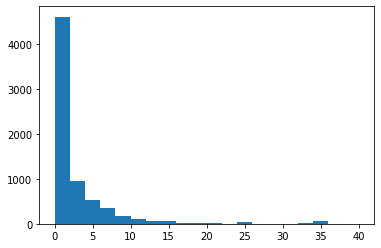

In [39]:
plt.hist(df_clean.xx_006,bins=20)
plt.show()

In [51]:
df_clean['xx_006'].fillna(0,inplace=True)
for var in df_clean.columns:
    df_clean[var].fillna(var+'_unknown',inplace=True)

In [52]:
df_clean = df_clean.drop_duplicates()

### Store a data_extra_base table without empty or duplicate features
This table is a combination of the data and extra table. The product is cleaned from empty and less than 10% filles variables, where id's with value 0 or features with value '999' have been identified as nan, subcategories have been renamed, and empty values are replaced with '\_unknown' (only categorical values had missing values). Duplicates are dropped. 

In [53]:
con = sqlite3.connect('../data/data2.db')
df_clean.to_sql(name='data_extra_base',con=con,if_exists='replace')
con.close()

### Merge with the error table

In [54]:
df_combo= pd.read_sql('SELECT da.*, err.id_034 as error FROM data_extra_base as da LEFT JOIN error_clean as err on datetime(err.dt_001)=datetime(da.dt_001) AND (err.id_001 == da.id_001)','sqlite:///../data/data2.db',index_col='index')
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38554 entries, 0 to 38431
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_013   38554 non-null  object 
 1   id_014   38554 non-null  object 
 2   xx_006   38554 non-null  float64
 3   cl_002   38554 non-null  object 
 4   cl_004   38554 non-null  object 
 5   flg_000  38554 non-null  object 
 6   flg_004  38554 non-null  object 
 7   id_000   38554 non-null  int64  
 8   ty_000   38554 non-null  object 
 9   cl_000   38554 non-null  object 
 10  xx_000   38554 non-null  object 
 11  id_001   38554 non-null  object 
 12  xx_001   38554 non-null  object 
 13  cl_001   38554 non-null  object 
 14  id_002   38554 non-null  object 
 15  id_003   38554 non-null  object 
 16  id_004   38554 non-null  object 
 17  id_005   38554 non-null  object 
 18  id_006   38554 non-null  object 
 19  id_007   38554 non-null  object 
 20  id_008   38554 non-null  object 
 21  xx_005   385

We see that we have 2008 non-zero errors among the 39169 jobs. Feature **id_034** is now labeled as **error** and is chosen to represent the jobs with errors and will be masked as 0 (no error) and 1 (error) below. It was just important to choose a 100% filled feature from the error table that is not contained in the mfque table.

In [55]:
df_combo.loc[:,'error'] = df_combo['error'].apply(lambda x: 0 if math.isnan(x) else 1)

Let's also make sure that we do not have duplicate rows.

In [56]:
df_combo.drop_duplicates(inplace= True)

For now, the other features remain as they are and will be dealt with in the Exploratory Data Analysis section.

## Save to SQL file

In [57]:
con = sqlite3.connect('../data/data2.db')
df_combo.to_sql(name='data_extra_base_error',con=con,if_exists='replace')
con.close()

## Reduce the number of categories

**!!! NOTE: THIS TECHNIQUE LIKELY REDUCES INFORMATION THAT MIGHT BE RELEVANT FOR THE ERRORS SINCE THE CFC DOES NOT TAKE THE RELEVANCE FOR THE ERRORS INTO ACCOUNT !!!!**

### Make exemplary Cummulative Frequency Curve plot

In [85]:
def cfc(data):
    # Cumulative frequency curve
    # Determine x and y values for the cummulative Frequency Curve based on the counts in data
    # data: counts of occurance of several features
    #returns the category counts x and the relative count/occurance of the individual category

    data = -1* np.sort(-data)
    total = sum(data)
    y = [data[0]] 
    for yi in data[1:]:
        y.append(yi+y[-1])
    y = y/total
    x = np.arange(1,len(data)+1)/len(data)
    return x,y;

In [83]:
df.columns

Index(['id_000', 'ty_000', 'cl_000', 'xx_000', 'id_001', 'xx_001', 'cl_001',
       'id_002', 'id_003', 'id_004', 'id_005', 'id_006', 'id_007', 'id_008',
       'xx_005', 'ty_002', 'ty_004', 'cl_003', 'id_018', 'id_019', 'cl_005',
       'xx_014', 'cl_006', 'cl_007', 'cl_008', 'id_024', 'xx_016', 'id_026',
       'flg_001', 'xx_026', 'dt_001', 'xx_027', 'xx_028', 'xx_029', 'ty_006',
       'id_033', 'error'],
      dtype='object')

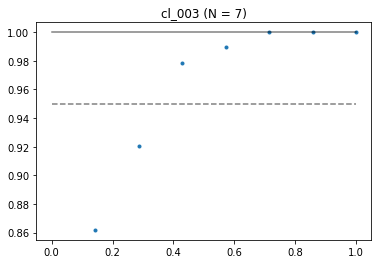

In [87]:
df = pd.read_sql('SELECT * FROM data_base_error','sqlite:///../data/data2.db',index_col='index')

var = 'cl_003'
counts = df[var].value_counts()
x, y = cfc(counts)
plt.plot(x,y,'.')
#mu = np.mean(counts)
#sigma = np.std(counts)
#samples = np.random.normal(mu,sigma,size=10000)
#x_theor, y_theor = cfc(samples)
#plt.plot(x_theor,y_theor)
plt.plot([0,1],[0.95,0.95],'k--',alpha=0.5)
plt.plot([0,1],[1,1],'k',alpha=0.5)
plt.title('{} (N = {})'.format(var,len(counts)))
plt.show()
#print(np.round(mu,2),np.round(sigma,2))

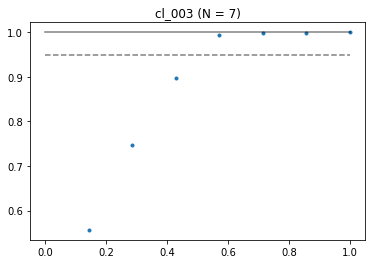

In [88]:
df = pd.read_sql('SELECT * FROM data_base_error','sqlite:///../data/data2.db',index_col='index')

var = 'cl_003'
counts = df.loc[df['error']==1,var].value_counts()
x, y = cfc(counts)
plt.plot(x,y,'.')
#mu = np.mean(counts)
#sigma = np.std(counts)
#samples = np.random.normal(mu,sigma,size=10000)
#x_theor, y_theor = cfc(samples)
#plt.plot(x_theor,y_theor)
plt.plot([0,1],[0.95,0.95],'k--',alpha=0.5)
plt.plot([0,1],[1,1],'k',alpha=0.5)
plt.title('{} (N = {})'.format(var,len(counts)))
plt.show()
#print(np.round(mu,2),np.round(sigma,2))

The example above shows, that it takes only 3 out of 7 categories to represent over 95% of the data set. Furthermore, there is 1 category that represents more than 85% of the data.

Below we analyze categorical features for their potential to reduce the number of categories by replacing categories which contribute only to the final 5% of the cumulative frequency. Dummies for the remaining categories are created.

In [23]:
df_reduced = df.copy()
for var in df.columns:   #['client']:# 
    if type(df[var][0]) != str:
        print(var, ' is not a string')
        continue
    counts = df[var].value_counts()
    x,y = cfc(counts)
    if len(counts) == 1:
        print('{} has only one category, namely {}.'.format(var,counts.index[0]))
        df_reduced.drop(var,axis=1,inplace=True)
    elif len(counts) == 2:
        if (1 in counts.index) & (0 in counts.index):
            print('{} remains {} and {}.'.format(var,counts.index[0],counts.index[1]))
            continue
        elif ('1' in counts.index) & ('0' in counts.index):
            df_reduced.loc[:,var] = df_reduced[var].astype(int)
        print('{} has only two categories, namely {} and {}.'.format(var,counts.index[0],counts.index[1]))
    elif len(counts) == len(df[var]):
        print('{} has only unique values.'.format(var))    
    elif min(y) > 0.95:
        df_reduced.loc[df_reduced[var].isin(counts.index[1:]),var] = var +'_other'
    else:
        ind = np.max(np.where(y <= 0.95)[0])
        if (ind <= 0.75 * len(counts.index)) & (ind < 10):
            df_reduced.loc[df_reduced[var].isin(counts.index[ind+1:]),var] = var +'_other'
            print('For {} {} entries were reduced.'.format(var,sum(df_reduced[var]==var +'_other')))
        else:
            print('{} does not have enough dominant features.'.format(var))

id_013 does not have enough dominant features.
id_014 does not have enough dominant features.
xx_006  is not a string
id_016 does not have enough dominant features.
cl_002 has only two categories, namely cl_002_unknown and cl_002_000.
For cl_004 6138 entries were reduced.
For flg_000 7652 entries were reduced.
id_000  is not a string
For ty_000 4042 entries were reduced.
cl_000 has only two categories, namely cl_000_000 and cl_000_001.
For xx_000 5879 entries were reduced.
id_001 does not have enough dominant features.
xx_001 has only two categories, namely xx_001_000 and xx_001_unknown.
For cl_001 8486 entries were reduced.
For id_002 12717 entries were reduced.
For id_003 2399 entries were reduced.
id_004 does not have enough dominant features.
For id_005 2403 entries were reduced.
id_006 does not have enough dominant features.
For id_007 1977 entries were reduced.
id_008 does not have enough dominant features.
xx_005  is not a string
For ty_002 2274 entries were reduced.
ty_004 has 